**1. Setup & Imports**

In this section, I load all the essential libraries needed for building and evaluating the CIFAR-10 image classification model. These include TensorFlow for deep learning, NumPy for numerical operations, Matplotlib for visualization, and Scikit-Learn for performance metrics.


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


**2. CIFAR-10 Dataset Overview**

CIFAR-10 is a widely-used image dataset containing:

60,000 colour images

32 × 32 resolution

10 object categories

Examples of classes include airplanes, cars, birds, cats, and more.
This dataset is perfect for demonstrating computer vision pipelines and MLOps workflows because it's lightweight but expressive.

In [8]:
# Load CIFAR-10 dataset (60,000 colour images, 32x32, 10 classes)
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train_full = y_train_full.flatten()
y_test = y_test.flatten()

class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("Full train shape:", x_train_full.shape, "Test shape:", x_test.shape)
print("Number of classes:", len(class_names))


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Full train shape: (50000, 32, 32, 3) Test shape: (10000, 32, 32, 3)
Number of classes: 10


train / validation split + normalize

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Normalize to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_val   = x_val.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)


Train: (40000, 32, 32, 3) Val: (10000, 32, 32, 3) Test: (10000, 32, 32, 3)


**4. Visual Insight: Sample Images**

Before training the model, it's useful to visually inspect a few sample images.
This gives a quick intuition of:

What the data looks like

The variety and complexity of images

How challenging the classification task might be

I display 8 random images from the training set along with their true class labels.

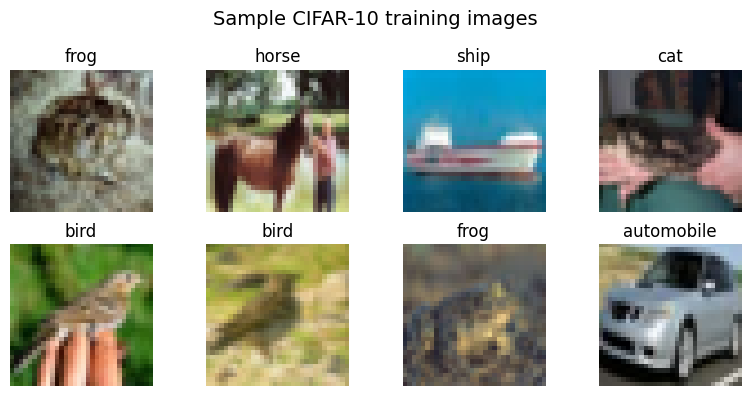

In [10]:
plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis("off")
plt.suptitle("Sample CIFAR-10 training images", fontsize=14)
plt.tight_layout()
plt.show()


**5. Data Pipeline with Augmentation**

To improve the model’s robustness, I apply data augmentation, including:

Horizontal flipping

Minor rotations

Light zoom transformations

This simulates natural variations in images, helping the model learn features that generalize better.

I also convert the training, validation, and test sets into efficient tf.data pipelines, which improve performance during training.

In [11]:
batch_size = 64
input_shape = (32, 32, 3)
num_classes = 10


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)


train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)


**Building the CNN Model**

In this section, I define the Convolutional Neural Network (CNN) architecture used for CIFAR-10 classification.

The model includes:

Three convolutional blocks with batch normalization

Max-pooling layers to reduce spatial dimensions

A dense classification head with dropout for regularization

A softmax output layer for 10-class prediction

This is a relatively lightweight but effective model, making it ideal for a project that must train quickly while still producing solid accuracy.

In [12]:
def build_model(input_shape=(32, 32, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)  # regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cifar10_cnn")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

model = build_model(input_shape, num_classes)
model.summary()


Model: "cifar10_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 621,258 (2.37 MB)

 Trainable params: 620,810 (2.37 MB)

 Non-trainable params: 448 (1.75 KB)

**Train model with EarlyStopping**

Training deep learning models requires a balance between learning enough and avoiding overfitting.

To handle this:

I use EarlyStopping, which monitors the validation loss.

If the model stops improving for a few epochs, training ends.

The best weights are automatically restored.

This helps the model generalize better and reduces unnecessary training time.

During training, you’ll see both:

Training accuracy/loss

Validation accuracy/loss

so you can visually track progress.

In [13]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=[early_stopping]
)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.3278 - loss: 1.9952 - val_accuracy: 0.5028 - val_loss: 1.3695
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4497 - loss: 1.5034 - val_accuracy: 0.5347 - val_loss: 1.3188
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5126 - loss: 1.3749 - val_accuracy: 0.5747 - val_loss: 1.2200
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5438 - loss: 1.2746 - val_accuracy: 0.6027 - val_loss: 1.1091
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5721 - loss: 1.2039 - val_accuracy: 0.5920 - val_loss: 1.1495
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5946 - loss: 1.1591 - val_accuracy: 0.6393 - val_loss: 1.0222
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6100 - loss: 1.1110 - val_accuracy: 0.6329 - val_loss: 1.0508
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6293 - loss: 1.0724 - val_acc

Plot training curves (Accuracy & Loss)

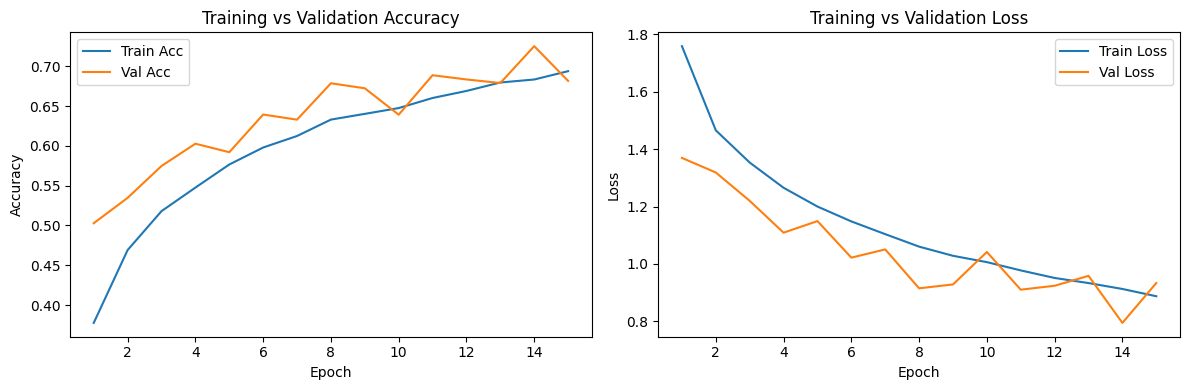

In [14]:
def plot_history(hist):
    hist_dict = hist.history
    epochs_range = range(1, len(hist_dict["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, hist_dict["accuracy"], label="Train Acc")
    plt.plot(epochs_range, hist_dict["val_accuracy"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, hist_dict["loss"], label="Train Loss")
    plt.plot(epochs_range, hist_dict["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


Evaluate on test set with multiple metrics

In [15]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


test_acc = accuracy_score(y_test, y_pred)
test_prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
test_rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
test_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")
print(f"Test F1-score:  {test_f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Accuracy:  0.7182
Test Precision: 0.7298
Test Recall:    0.7182
Test F1-score:  0.7164

Classification Report:

              precision    recall  f1-score   support

    airplane       0.72      0.80      0.75      1000
  automobile       0.80      0.90      0.85      1000
        bird       0.68      0.59      0.63      1000
         cat       0.53      0.49      0.51      1000
        deer       0.79      0.57      0.66      1000
         dog       0.56      0.76      0.64      1000
        frog       0.75      0.84      0.79      1000
       horse       0.75      0.80      0.77      1000
        ship       0.95      0.64      0.76      1000
       truck       0.77      0.79      0.78      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000



Confusion matrix

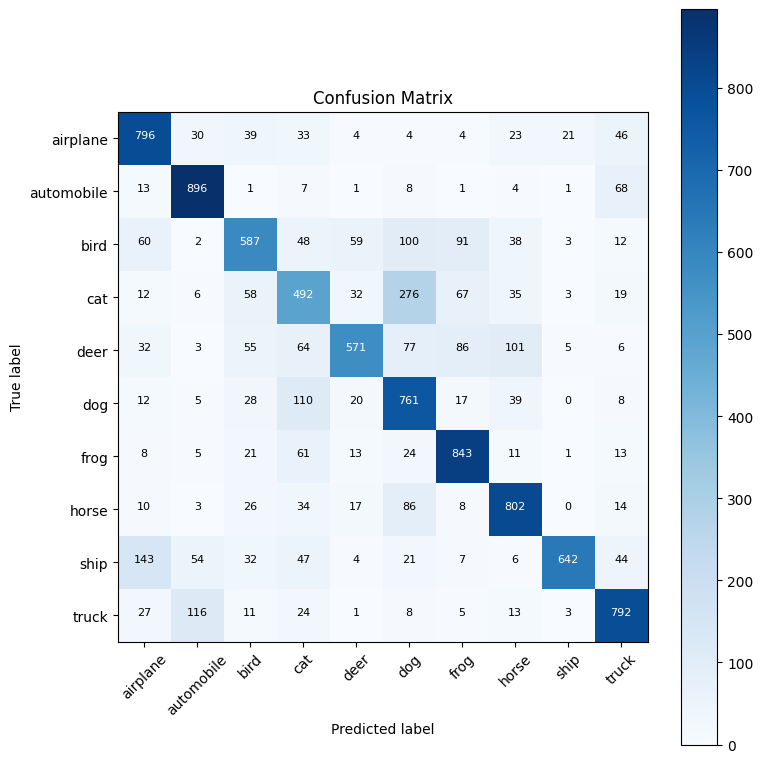

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=8
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


Save

In [17]:
os.makedirs("models", exist_ok=True)
model_path = "models/base_cifar10_model.h5"
model.save(model_path)
print("Model saved to:", model_path)


Model saved to: models/base_cifar10_model.h5


prediction demo for ONE image

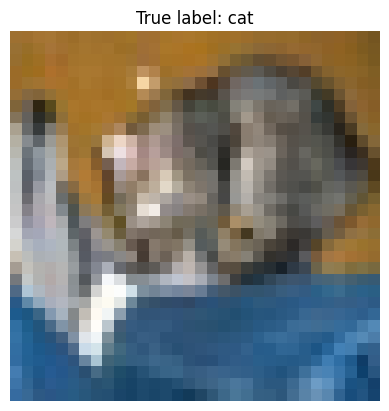

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Predicted: dog (confidence 0.84)


In [18]:
idx = 0
single_image = x_test[idx]
single_label = y_test[idx]

plt.imshow(single_image)
plt.axis("off")
plt.title(f"True label: {class_names[single_label]}")
plt.show()


single_image_batch = np.expand_dims(single_image, axis=0)

single_pred_probs = model.predict(single_image_batch)[0]
single_pred_idx = np.argmax(single_pred_probs)
single_pred_class = class_names[single_pred_idx]
single_pred_conf = single_pred_probs[single_pred_idx]

print(f"Predicted: {single_pred_class} (confidence {single_pred_conf:.2f})")


In [19]:
%pwd


'/content/mlops-image-classification'

In [20]:
%cd /content
!git clone https://github.com/Solomon-the-octave/mlops-image-classification.git
%cd mlops-image-classification
!ls


/content
fatal: destination path 'mlops-image-classification' already exists and is not an empty directory.
/content/mlops-image-classification
app.py	data  locustfile.py  models  notebook  README.md  requirements.txt  src


In [21]:
%cd /content/mlops-image-classification


/content/mlops-image-classification


In [22]:
notebook/mlops_image.ipynb


In [23]:
import os
os.makedirs("models", exist_ok=True)
model.save("models/base_cifar10_model.h5")
print("Model saved!")


Model saved!


In [62]:
%pwd


'/content/mlops-image-classification'

In [63]:
%cd /content


/content


In [64]:
# === CREATE A SMALL NEW DATASET FOR RETRAINING ===


x_new = x_train_full[:500]
y_new = y_train_full[:500]

np.savez("new_data.npz", x_new=x_new, y_new=y_new)

print("Created new_data.npz successfully!")


Created new_data.npz successfully!


## RETRAINING DEMO – Upload, Preprocess, Retrain


In [69]:
import os


os.makedirs("models", exist_ok=True)


model.save("models/base_cifar10_model.h5")
print("Base model saved to: models/base_cifar10_model.h5")

!ls -lh models


Base model saved to: models/base_cifar10_model.h5
total 7.2M
-rw-r--r-- 1 root root 7.2M Nov 27 17:14 base_cifar10_model.h5


In [70]:
#  RETRAINING DEMO

from google.colab import files
import numpy as np
import os

os.makedirs("data", exist_ok=True)

print("Please upload a .npz file containing 'x_new' and 'y_new'")
uploaded = files.upload()


new_data_filename = list(uploaded.keys())[0]
new_data_path = os.path.join("data", new_data_filename)


os.rename(new_data_filename, new_data_path)

print("Uploaded file saved to:", new_data_path)


Please upload a .npz file containing 'x_new' and 'y_new'


Saving new_data.npz to new_data (1).npz
Uploaded file saved to: data/new_data (1).npz


In [71]:
#  RETRAINING DEMO

data = np.load(new_data_path)

x_new = data["x_new"].astype("float32") / 255.0
y_new = data["y_new"]

print("x_new shape:", x_new.shape)
print("y_new shape:", y_new.shape)


batch_size = 64
new_ds = tf.data.Dataset.from_tensor_slices((x_new, y_new)).batch(batch_size)


x_new shape: (500, 32, 32, 3)
y_new shape: (500,)


In [73]:
#  Retrain starting from the ALREADY-TRAINED model in memory ===


retrain_model = model

retrain_history = retrain_model.fit(
    x_new,
    y_new,
    epochs=2,
    validation_data=(x_val, y_val)
)

import os
os.makedirs("models", exist_ok=True)
retrained_model_path = "models/retrained_cifar10_model.h5"
retrain_model.save(retrained_model_path)
print("Retrained model saved to:", retrained_model_path)


Epoch 1/2
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7383 - loss: 0.7845 - val_accuracy: 0.7118 - val_loss: 0.8698
Epoch 2/2
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7650 - loss: 0.7417 - val_accuracy: 0.6671 - val_loss: 1.0397


Retrained model saved to: models/retrained_cifar10_model.h5


In [74]:

%cd /content

!ls -lh models

!cp models/base_cifar10_model.h5 mlops-image-classification/models/base_cifar10_model.h5

!ls -lh mlops-image-classification/models


/content
total 15M
-rw-r--r-- 1 root root 7.2M Nov 27 17:14 base_cifar10_model.h5
-rw-r--r-- 1 root root 7.2M Nov 27 17:19 retrained_cifar10_model.h5
total 7.2M
-rw-r--r-- 1 root root 7.2M Nov 27 17:29 base_cifar10_model.h5
